### Курсовой проект
##### Предсказание стоимости недвижимости

In [1]:
import numpy as np         # Импорт необходимых библиотек
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [ ]:
TRAIN_DATASET_PATH = '../input/real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = '../input/real-estate-price-prediction-moscow/test.csv'

In [ ]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [ ]:
# Выясняем размеры обучающей и тестовой выборок
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


In [ ]:
train_df.info()      # Тут мы посмотрим на типы данных и пропуски в них

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [ ]:
train_df['Id'] = train_df['Id'].astype(str)             # Id и DistrictId приводим к строковому типу
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

In [ ]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


# EDA

Text(0.5, 0, 'Price')

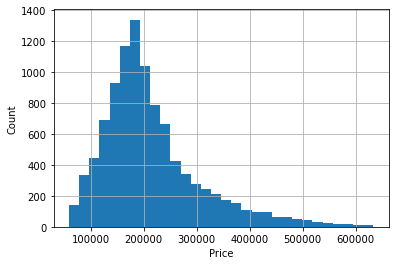

In [ ]:
train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

На графике распределения целевой переменной не замечено выбросов

##### Обработка выбросов

In [ ]:
train_df['Rooms'].value_counts()     # А тут мы видим выброс - "бескомнатные" квартиры в количестве 8 шт

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

In [ ]:
train_df[train_df['Rooms'] == 19].head()    # Странная квартира с 19 комнатами площадью 42 м2. Значит это выброс

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
6088,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.616704


In [ ]:
train_df[train_df['Rooms'] == 10].head()    # то же касается и 10 комнатных квартир

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2004,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.323792
2728,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.270863


In [ ]:
train_df[train_df['Rooms'] == 6].head()    # В теории возможно налепить 6 комнат на 59.4 м2... Но по факту это снова выброс

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
8794,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.964416


Удаляю строки с выбросными данными

In [ ]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df = train_df.loc[train_df['Rooms_outlier'] != 1]

In [ ]:
train_df[train_df['HouseYear'] > 2020].head()     # Ищем дома "из будущего"

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
8828,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,...,B,25,4756,16,2857.0,5,8,B,243028.603096,0
9163,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,...,B,30,6141,10,262.0,3,6,B,254084.534396,0


In [ ]:
# "Дома из будущего" также удаляю
train_df = train_df.loc[train_df['HouseYear'] <= 2021]

In [ ]:
# Проверим площадь кузни
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1168
10.0      1073
6.0       1037
9.0        841
0.0        690
7.0        608
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
112.0        2
51.0         2
58.0         2
37.0         2
32.0         2
41.0         2
43.0         2
30.0         2
25.0         2
39.0         1
23.0         1
123.0        1
40.0         1
48.0         1
21.0         1
72.0         1
27.0         1
63.0         1
1970.0       1
29.0         1
66.0         1
2014.0       1
31.0         1
78.0         1
35.0         1
42.0         1
73.0         1
60.0         1
84.0         1
26.0         1
54.0         1
36.0         1
53.0         1
96.0         1
62.0         1
75.0         1
Name: KitchenSquare, dtype: int64

Приведем данные по площади кухни в порядок

In [ ]:
train_df['KitchenSquare'].quantile(.95)

12.0

In [ ]:
# Все что больше 12 м2 и нулевые значения заменяем медианой, а меньше 3 м2 заменим на 3
condition = (train_df['KitchenSquare'].isna()) | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.95)) 
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [ ]:
# Вот что в итоге
train_df['KitchenSquare'].value_counts()

3.0     3176
8.0     1306
6.0     1293
5.0     1168
10.0    1073
9.0      841
7.0      608
12.0     249
11.0     233
4.0       39
Name: KitchenSquare, dtype: int64

"Парящие в небе" квартиры и безэтажные дома

In [ ]:
train_df['Floor_outlier'] = 0
train_df.loc[(train_df['Floor'] == 0) | (train_df['Floor'] > train_df['HouseFloor']), 'Floor_outlier'] = 1
train_df['Floor_outlier'].value_counts()

0    8167
1    1819
Name: Floor_outlier, dtype: int64

In [ ]:
# Заменяем "парящие" этажи на последний этаж, дома с 0 этажей и NaN заменяем на медиану
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()
train_df.loc[train_df['HouseFloor'].isna(), 'HouseFloor'] = train_df['HouseFloor'].median()
train_df.loc[train_df['Floor_outlier'] == 1, 'Floor'] = train_df['HouseFloor']
train_df.head()
train_df['Floor_outlier'].value_counts()

0    8167
1    1819
Name: Floor_outlier, dtype: int64

##### Пропуски в данных

In [ ]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2110
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4790
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
Rooms_outlier       0
Floor_outlier       0
dtype: int64

In [ ]:
# Ставим метку на строки с пропусками
train_df['LifeSquare_nan'] = 0
train_df.loc[train_df['LifeSquare'].isna(), 'LifeSquare_nan'] = 1
train_df.loc[train_df['LifeSquare_nan'] == 1].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Floor_outlier,LifeSquare_nan
0,11809,27,3.0,115.027311,NaN,10.0,4.0,10.0,2014,0.075424,...,3097,0,NaN,0,0,B,305018.871089,0,0,1
3,2352,1,1.0,40.409907,NaN,3.0,10.0,22.0,1977,0.007122,...,264,0,NaN,0,1,B,168106.007630,0,0,1
18,4581,1,1.0,47.582480,NaN,3.0,16.0,16.0,1977,0.007122,...,264,0,NaN,0,1,B,128803.593810,0,0,1
20,8768,63,1.0,50.974891,NaN,3.0,7.0,16.0,2018,0.238617,...,3889,6,705.0,3,6,B,260328.413376,0,0,1
24,4717,27,1.0,44.203947,NaN,3.0,13.0,13.0,1977,0.072158,...,629,1,NaN,0,0,A,135466.559958,0,1,1


In [ ]:
# Заполняем пропуски в жилой площади
life_square_nan = (train_df['LifeSquare_nan'] == 1)
train_df.loc[life_square_nan, 'LifeSquare'] =\
train_df.loc[life_square_nan, 'Square'] - train_df.loc[life_square_nan, 'KitchenSquare'] - 3
train_df.loc[train_df['LifeSquare_nan'] == 1].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Floor_outlier,LifeSquare_nan
0,11809,27,3.0,115.027311,102.027311,10.0,4.0,10.0,2014,0.075424,...,3097,0,NaN,0,0,B,305018.871089,0,0,1
3,2352,1,1.0,40.409907,34.409907,3.0,10.0,22.0,1977,0.007122,...,264,0,NaN,0,1,B,168106.007630,0,0,1
18,4581,1,1.0,47.582480,41.582480,3.0,16.0,16.0,1977,0.007122,...,264,0,NaN,0,1,B,128803.593810,0,0,1
20,8768,63,1.0,50.974891,44.974891,3.0,7.0,16.0,2018,0.238617,...,3889,6,705.0,3,6,B,260328.413376,0,0,1
24,4717,27,1.0,44.203947,38.203947,3.0,13.0,13.0,1977,0.072158,...,629,1,NaN,0,0,A,135466.559958,0,1,1


In [ ]:
# Удаляем признак Healthcare_1 в виду большого количества пропусков
train_df.drop('Healthcare_1', axis=1, inplace=True)

In [ ]:
# Просмотр результатов обработки пропусков
train_df.isna().sum()

Id                0
DistrictId        0
Rooms             0
Square            0
LifeSquare        0
KitchenSquare     0
Floor             0
HouseFloor        0
HouseYear         0
Ecology_1         0
Ecology_2         0
Ecology_3         0
Social_1          0
Social_2          0
Social_3          0
Helthcare_2       0
Shops_1           0
Shops_2           0
Price             0
Rooms_outlier     0
Floor_outlier     0
LifeSquare_nan    0
dtype: int64

Заменяем буквенные параметры на числовые

In [ ]:
# Создам словарь со значениями для замены
binary_to_numbers = {'A': 0, 'B': 1}
train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

Замена параметра DistrictId на размер района 

In [ ]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
train_df = train_df.merge(district_size, on='DistrictId', how='left')

##### Генерация нового признака
средняя цена квадратного метра по району <b>MeanSqMpriceByDistr</b>

In [ ]:
train_df['sqm_price'] = train_df['Price'] / train_df['Square']
mean_sqm_price_by_district = train_df.groupby(['DistrictId'], as_index=False).agg({'sqm_price':'mean'})\
                            .rename(columns={'sqm_price':'MeanSqMpriceByDistr'})

mean_sqm_price_by_district.head(10)

,DistrictId,MeanSqMpriceByDistr
0,0,3710.401014
1,1,3525.385253
2,10,4377.498005
3,100,5093.929852
4,101,4177.749766
5,102,2971.094045
6,103,5010.327398
7,104,6213.461260
8,105,4670.074261
9,106,4224.344734


In [ ]:
# Присоединяем новый признак к исходному датафрейму
train_df = train_df.merge(mean_sqm_price_by_district, on=['DistrictId'], how='left')
train_df.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Floor_outlier,LifeSquare_nan,DistrictSize,sqm_price,MeanSqMpriceByDistr
0,11809,27,3.0,115.027311,102.027311,10.0,4.0,10.0,2014,0.075424,...,0,0,1,305018.871089,0,0,1,846,2651.708272,2856.818234
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,1,0,1,177734.553407,0,0,0,78,4462.045990,3738.867404
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,3,1,1,282078.720850,0,0,0,651,3600.596698,3525.385253
3,2352,1,1.0,40.409907,34.409907,3.0,10.0,22.0,1977,0.007122,...,0,1,1,168106.007630,0,0,1,651,4160.019670,3525.385253
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,0,6,1,343995.102962,0,0,0,89,5351.088794,4194.536925
5,5804,99,3.0,62.528465,47.103833,6.0,9.0,9.0,1972,0.012339,...,2,4,1,161044.944138,0,0,0,96,2575.546115,3939.089003
6,8864,44,1.0,33.938750,21.772930,9.0,1.0,12.0,1968,0.232205,...,0,3,1,142402.739272,0,0,0,104,4195.874603,4572.483767
7,13072,59,2.0,50.391814,32.893256,8.0,8.0,17.0,1986,0.019509,...,5,5,1,326174.175191,0,0,0,67,6472.761106,4746.494431
8,9951,1,1.0,46.887892,44.628132,3.0,12.0,20.0,1977,0.007122,...,0,1,1,160400.401732,0,0,0,651,3420.934395,3525.385253
9,8094,6,3.0,79.867477,75.085125,3.0,3.0,17.0,2014,0.243205,...,0,0,1,194756.023945,0,0,0,510,2438.489759,3004.555848


##### Подготовка классов обработки данных и генерации новых признаков

In [ ]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.95)
        
    def throw_and_forget(self, X):
        # Отдельная функция для удаления выбросов в трейне
        ## HouseYear
        current_year = datetime.now().year        
        X = X.loc[X['HouseYear'] <= 2021]
        
        ## Rooms
        # X['Rooms_outlier'] = 0
        # X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        # Удаление неформатных квартир
        X = X.loc[(X['Rooms'] != 0) | (X['Rooms'] < 6)]
        
        return X
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        # На тесте выбросы заменяем на медианы, а нулевые комнаты заменяем на единицу
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = X['Rooms'].median()

        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor, Floor
        
        X['Floor_outlier'] = 0
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['HouseFloor'].isna(), 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['Floor_outlier'] == 1, 'Floor'] = X['HouseFloor']
        
        
        # HouseYear
        current_year = datetime.now().year
        
        X = X.loc[X['HouseYear'] <= current_year]
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = 0
        X.loc[X['LifeSquare'].isna(), 'LifeSquare_nan'] = 1
        
        life_square_nan = (X['LifeSquare_nan'] == 1)
        X.loc[life_square_nan, 'LifeSquare'] =\
        X.loc[life_square_nan, 'Square'] - X.loc[life_square_nan, 'KitchenSquare'] - 3
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

In [ ]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.mean_sqm_price_by_district = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        
        # Target encoding
        # df = X.copy()
        
        if y is not None:
            X['Price'] = y.values
        
        X['sqm_price'] = X['Price'] / X['Square']
        self.mean_sqm_price_by_district = X.groupby(['DistrictId'], as_index=False).agg({'sqm_price':'mean'})\
                            .rename(columns={'sqm_price':'MeanSqMpriceByDistr'})
        #self.mean_sqm_price_by_district = self.mean_sqm_price_by_district['MeanSqMpriceByDistr'].median()
            
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId
        X = X.merge(self.district_size, on='DistrictId', how='left')
        X['DistrictSize'].fillna(5, inplace=True)
        
        # Target encoding
        # if mean_sqm_price_by_district is not None:
        X = X.merge(self.mean_sqm_price_by_district, on=['DistrictId'], how='left')
        X['MeanSqMpriceByDistr'].fillna(self.mean_sqm_price_by_district['MeanSqMpriceByDistr'].median(), inplace=True)
        
        return X

### Загрузка данных

In [ ]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'Floor_outlier',
 'LifeSquare_nan',
 'DistrictSize',
 'sqm_price',
 'MeanSqMpriceByDistr']

In [ ]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['DistrictSize', 'MeanSqMpriceByDistr']

target_name = 'Price'

In [ ]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [ ]:
preprocessor = DataPreprocessing()
preprocessor.fit(train_df)

train_df = preprocessor.throw_and_forget(train_df)

In [ ]:
X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [ ]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

((6698, 20), (3300, 20), (5000, 20))

In [ ]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)
features_gen.fit(X_valid, y_valid)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6698, 22), (3300, 22), (5000, 22))

In [ ]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

### Обучение модели

Построение модели

In [ ]:
# Случайный лес
parameters = {
    'n_estimators': 1000,
    'max_depth': 12,
    'random_state': 42
}
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

RandomForestRegressor()

Оценка модели

Train R2:	0.962
Test R2:	0.752


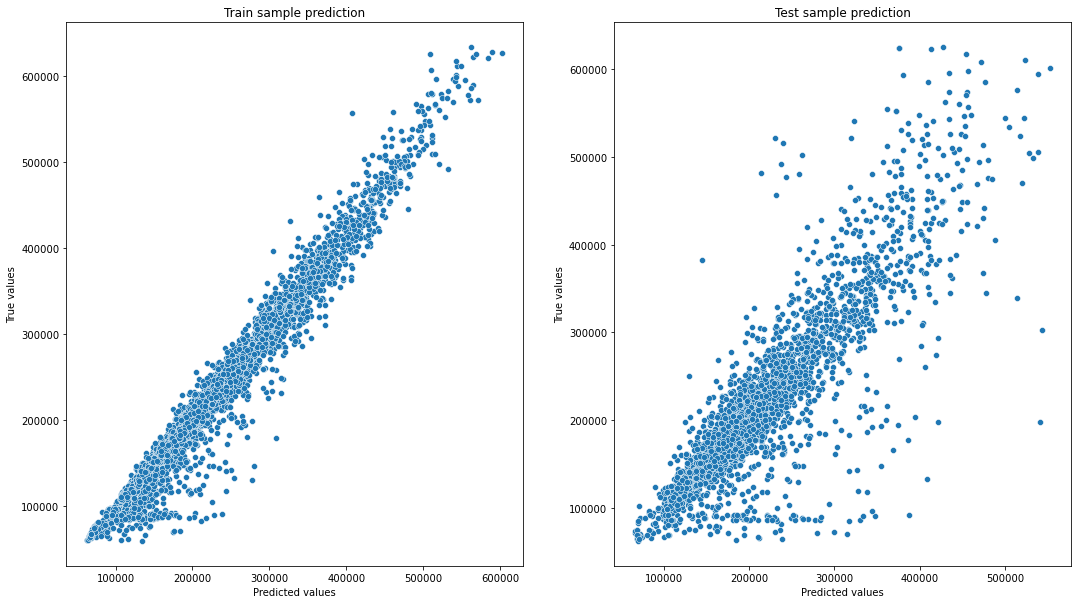

In [ ]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [ ]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=42))
cv_score

array([0.74094914, 0.71154824, 0.68457405])

In [ ]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
3,Square,0.411491
21,MeanSqMpriceByDistr,0.227084
20,DistrictSize,0.081673
4,LifeSquare,0.030629
8,HouseYear,0.026719
2,Rooms,0.024706
0,Id,0.023831
12,Social_1,0.022824
14,Social_3,0.021247
13,Social_2,0.020349


In [ ]:
# Бустинг
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)

GradientBoostingRegressor()

Train R2:	0.785
Test R2:	0.754


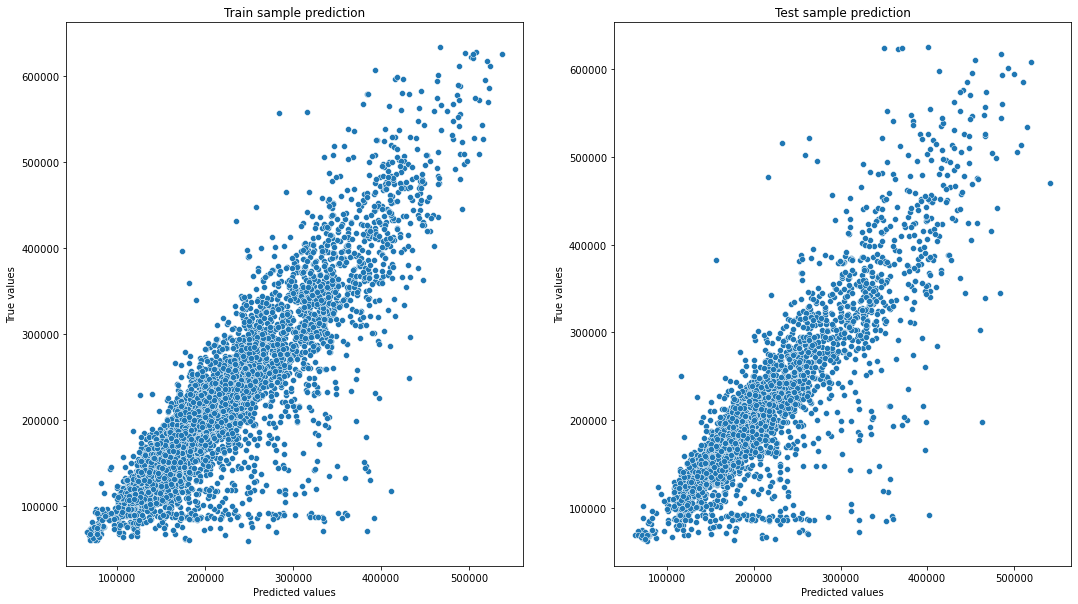

In [ ]:
y_train_preds = gb.predict(X_train)
y_valid_preds = gb.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

In [ ]:
# Линейная регрессия
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
scaler = StandardScaler()
# Стандартизация признаков
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.fit_transform(X_valid)

In [ ]:
lr.fit(X_train_scaled, y_train)   # Обучаем модель

LinearRegression()

Train R2:	0.581
Test R2:	0.63


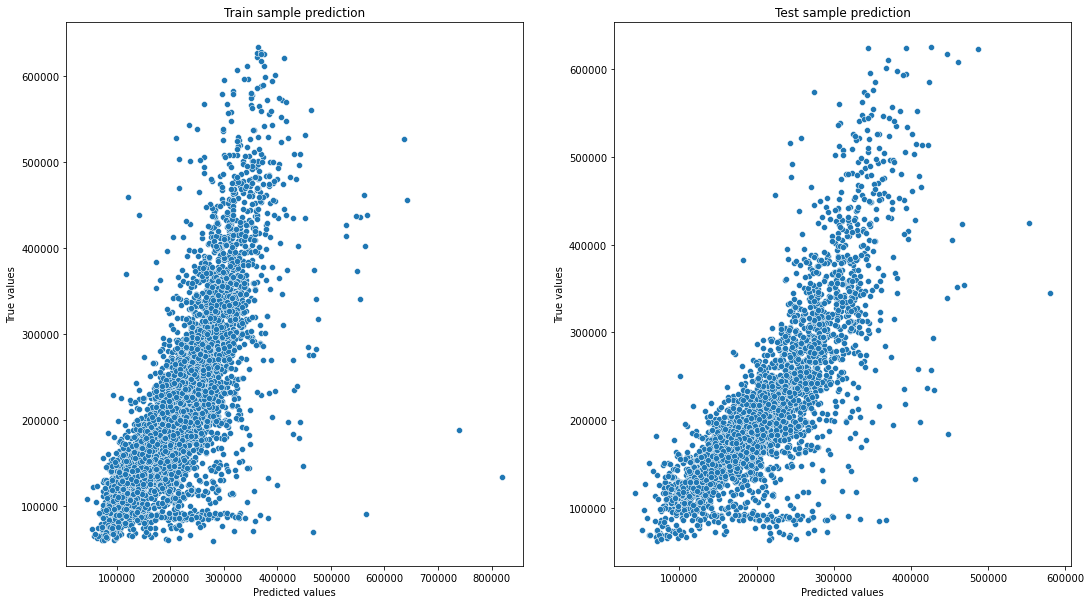

In [ ]:
# Оценка модели
y_train_preds = lr.predict(X_train_scaled)
y_valid_preds = lr.predict(X_valid_scaled)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

In [ ]:
# Стэкинг
from sklearn.ensemble import StackingRegressor
    
stc = StackingRegressor([('lr', lr), ('rf', rf_model)], final_estimator=gb)
stc.fit(X_train, y_train)

StackingRegressor(estimators=[('lr', LinearRegression()),
                              ('rf', RandomForestRegressor())],
                  final_estimator=GradientBoostingRegressor())

Train R2:	0.931
Test R2:	0.74


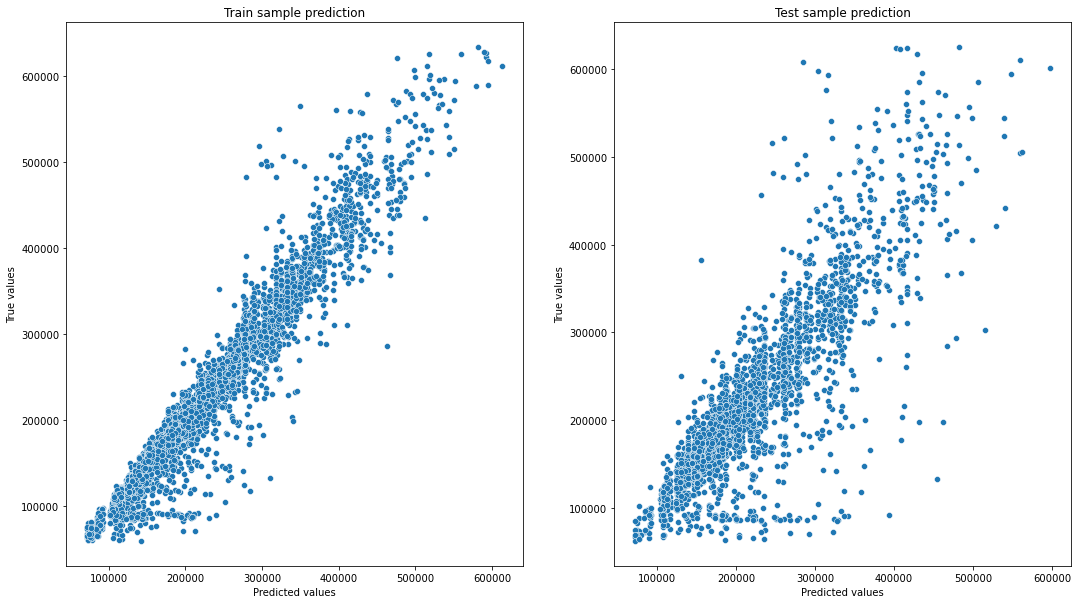

In [ ]:
# Оценка модели
y_train_preds = stc.predict(X_train)
y_valid_preds = stc.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

In [ ]:
# Вотинг
from sklearn.ensemble import VotingRegressor

vot = VotingRegressor([('lr', lr), ('gb', gb)])
vot.fit(X_train, y_train)

VotingRegressor(estimators=[('lr', LinearRegression()),
                            ('gb', GradientBoostingRegressor())])

Train R2:	0.72
Test R2:	0.72


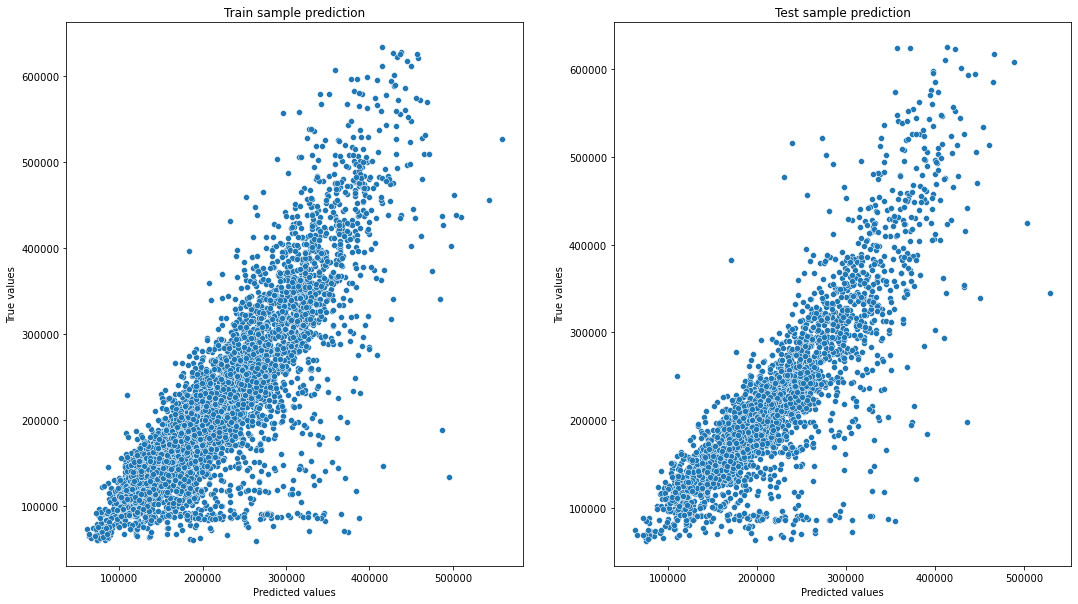

In [ ]:
# Оценка модели
y_train_preds = vot.predict(X_train)
y_valid_preds = vot.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

##### Делаем предсказание 1

In [ ]:
predictions  = gb.predict(test_df)

In [ ]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [ ]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,166071.378996
1,5925,120172.104166
2,960,166877.920674
3,3848,113883.865106
4,746,183175.522687


In [ ]:
submit.to_csv('gb_submit.csv', index=False)

##### Делаем предсказание 2

In [ ]:
predictions  = rf_model.predict(test_df)

In [ ]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,160299.515494
1,5925,119943.853060
2,960,141452.406503
3,3848,119715.777503
4,746,172575.343370


In [ ]:
submit.to_csv('rf_submit.csv', index=False)

##### Делаем предсказание 3

In [ ]:
predictions  = stc.predict(test_df)

In [ ]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,163983.891644
1,5925,126178.032479
2,960,141141.957045
3,3848,126178.032479
4,746,166946.414142


In [ ]:
submit.to_csv('stc_submit.csv', index=False)

##### Делаем предсказание 4

In [ ]:
predictions  = vot.predict(test_df)

In [ ]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,162924.236516
1,5925,132535.301847
2,960,171124.468019
3,3848,134549.183123
4,746,165253.473652


In [ ]:
submit.to_csv('vot_submit.csv', index=False)